<a href="https://colab.research.google.com/github/akhrna65/Detection-of-emotion-from-different-speakers-in-audio-segment/blob/main/Capstone_Project_MA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREDICTIVE MAINTENANCE**

**Multiclass Classification**\
Task: Predict which component (comp1, comp2, comp3, comp4) will fail within the next 48 hours.\

This is a multiclass classification problem where the model will learn from past patterns in telemetry, error, maintenance, and machine info to predict upcoming failures.

**Train a model on historical data where we do know the failures, so that it can predict future failures before they happen.**

 Dataset - simulate sensor readings and maintenance logs for machines in a manufacturing setting

**Telemetry.csv** - Time series sensor data recorded every hour\
**Errors.csv** - Error events triggered by machines\
**Maintenance.csv** - Maintenance events when specific components are replaced.\
**Failures.csv** - Actual recorded failures of machine components.\
**Machines.csv** - Metadata about each machine

**Basic Workflow**

1.   Merge all datasets on machineID and datetime
2. Create labels: For each timestamp, check if any component failed within the next 48 hours
3. Create features:
*   Rolling averages or standard deviations of telemetry (e.
g., last 3h, 6h, 24h)
*   Error counts in past hours
*   Time since last maintenance
4. Train a model like RandomForest, XGBoost, or LSTM (for time series)
5. Predict: Output one of: comp1, comp2, comp3, comp4, or none

> "If I already know the datetime of failure, why predict?"

Because you use those known times (in training) to teach a model what failure looks like ahead of time, so you can predict future failures before they occur.

> "On what machine does the prediction occur?"

The prediction is per machine (machineID) at each datetime.
So for every machine and every hour, the model says:

“Will any component fail within the next 24 hours? If yes, which one?”

In [ ]:
print("hellloooo")

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

### **1. Data Understanding**


In [ ]:
telemetry = pd.read_csv('/content/PdM_telemetry.csv')
errors = pd.read_csv('/content/PdM_errors.csv')
maint = pd.read_csv('/content/PdM_maint.csv')
failures = pd.read_csv('/content/PdM_failures.csv')
machines = pd.read_csv('/content/PdM_machines.csv')

In [ ]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [ ]:
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [ ]:
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [ ]:
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [ ]:
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


**Basic Overview for All Datasets**

In [ ]:
datasets = {
    'telemetry': telemetry,
    'errors': errors,
    'maint': maint,
    'failures': failures,
    'machines': machines
}

for name, df in datasets.items():
    print(f"\n📘 Dataset: {name.upper()}")
    print("-" * 50)
    print("Shape:", df.shape)
    print("-" * 50)
    print("Columns:", df.columns.tolist())
    print("-" * 50)
    print("Data Types:\n",df.dtypes)
    print("-" * 50)
    print("Null Values:\n",df.isnull().sum())
    print("-" * 50)
    print("Unique Values:\n",df.iloc[:, :10].nunique())
    print("-" * 50)



📘 Dataset: TELEMETRY
--------------------------------------------------
Shape: (876100, 6)
--------------------------------------------------
Columns: ['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration']
--------------------------------------------------
Data Types:
 datetime      object
machineID      int64
volt         float64
rotate       float64
pressure     float64
vibration    float64
dtype: object
--------------------------------------------------
Null Values:
 datetime     0
machineID    0
volt         0
rotate       0
pressure     0
vibration    0
dtype: int64
--------------------------------------------------
Unique Values:
 datetime       8761
machineID       100
volt         876100
rotate       876100
pressure     876100
vibration    876100
dtype: int64
--------------------------------------------------

📘 Dataset: ERRORS
--------------------------------------------------
Shape: (3919, 3)
--------------------------------------------------
Columns: ['datetim

**1. Telemetry (Sensor data every hour)**

In [ ]:
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'])

In [ ]:
print(telemetry['datetime'].min(), telemetry['datetime'].max()) #check min and max datetime
print("Unique machines:", telemetry['machineID'].nunique())     #see how many machine
telemetry.describe()

2015-01-01 06:00:00 2016-01-01 06:00:00
Unique machines: 100


,datetime,machineID,volt,rotate,pressure,vibration
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2015-07-02 18:00:00,50.500000,170.777736,446.605119,100.858668,40.385007
min,2015-01-01 06:00:00,1.000000,97.333604,138.432075,51.237106,14.877054
25%,2015-04-02 12:00:00,25.750000,160.304927,412.305714,93.498181,36.777299
50%,2015-07-02 18:00:00,50.500000,170.607338,447.558150,100.425559,40.237247
75%,2015-10-02 00:00:00,75.250000,181.004493,482.176600,107.555231,43.784938
max,2016-01-01 06:00:00,100.000000,255.124717,695.020984,185.951998,76.791072
std,NaN,28.866087,15.509114,52.673886,11.048679,5.370361


**2. Errors**

In [ ]:
errors['datetime'] = pd.to_datetime(errors['datetime'])   #convert datetime
errors.describe()

,datetime,machineID
count,3919,3919.000000
mean,2015-07-01 03:34:18.586374144,51.044654
min,2015-01-01 06:00:00,1.000000
25%,2015-03-31 05:00:00,25.000000
50%,2015-07-01 06:00:00,51.000000
75%,2015-10-01 15:00:00,77.000000
max,2016-01-01 05:00:00,100.000000
std,NaN,28.954988


**3. Failure**

In [ ]:
failures['datetime'] = pd.to_datetime(failures['datetime'])   #convert datetime
failures.describe()

,datetime,machineID
count,761,761.000000
mean,2015-06-24 12:12:17.976346880,51.911958
min,2015-01-02 03:00:00,1.000000
25%,2015-03-23 06:00:00,24.000000
50%,2015-06-24 06:00:00,51.000000
75%,2015-09-23 06:00:00,79.000000
max,2015-12-31 06:00:00,100.000000
std,NaN,29.515542


**4. Maintenance**

In [ ]:
maint['datetime'] = pd.to_datetime(maint['datetime'])   #convert datetime
maint.describe()

,datetime,machineID
count,3286,3286.000000
mean,2015-05-30 14:40:36.518563840,50.284236
min,2014-06-01 06:00:00,1.000000
25%,2015-03-03 06:00:00,25.250000
50%,2015-06-13 06:00:00,50.000000
75%,2015-09-18 00:00:00,75.000000
max,2016-01-01 06:00:00,100.000000
std,NaN,28.914478


**5. Machines**

In [ ]:
machines.describe()

,machineID,age
count,100.000000,100.000000
mean,50.500000,11.330000
std,29.011492,5.856974
min,1.000000,0.000000
25%,25.750000,6.750000
50%,50.500000,12.000000
75%,75.250000,16.000000
max,100.000000,20.000000


age: The number of months since the machine was installed or last maintained.

**Check for Duplicates**

In [ ]:
for name, df in datasets.items():
    print(f"{name}: duplicated rows = {df.duplicated().sum()}")

telemetry: duplicated rows = 0
errors: duplicated rows = 0
maint: duplicated rows = 0
failures: duplicated rows = 0
machines: duplicated rows = 0


### **2. Data Preparation**

**Merge dataset into data**

In [ ]:
#Merge telemetry + machines
data = telemetry.merge(machines, on='machineID', how='left')

In [ ]:
# Sort and force full datetime sort across entire dataset
data = data.sort_values(by=['datetime', 'machineID']).reset_index(drop=True)
errors = errors.sort_values(by=['datetime', 'machineID']).reset_index(drop=True)


In [ ]:
# Confirm sorted status
print("Data sorted:", data['datetime'].is_monotonic_increasing)
print("Errors sorted:", errors['datetime'].is_monotonic_increasing)

Data sorted: True
Errors sorted: True


In [ ]:
#Merge errors using merge_asof (within 1 hour)
data = pd.merge_asof(
    data, errors,
    on='datetime', by='machineID',
    direction='backward',
    tolerance=pd.Timedelta('1h'),
    suffixes=('', '_error')
)

In [ ]:
#Merge with maint

# Prepare maint
maint = maint.sort_values(by=['datetime', 'machineID']).reset_index(drop=True)

data = pd.merge_asof(
    data, maint,
    on='datetime', by='machineID',
    direction='backward',
    tolerance=pd.Timedelta('1h'),
    suffixes=('', '_maint')
)

In [ ]:
#merge with failures

failures = failures.sort_values(by=['datetime', 'machineID']).reset_index(drop=True)

data = pd.merge_asof(
    data, failures,
    on='datetime', by='machineID',
    direction='backward',
    tolerance=pd.Timedelta('1h'),
    suffixes=('', '_fail')
)

**Create Multiclass Failure Label (within next 24h)**

In [ ]:
# Create a new column to store failure type (None by default)
data['failure_label'] = 'none'

# Loop through each failure and assign label if within next 24h
for idx, row in failures.iterrows():
    affected_rows = (
        (data['machineID'] == row['machineID']) &
        (data['datetime'] >= row['datetime'] - pd.Timedelta(hours=24)) &
        (data['datetime'] < row['datetime'])
    )
    data.loc[affected_rows, 'failure_label'] = row['failure']


'none' → no failure in next 24h

'comp1', 'comp2', etc. → if failure is expected in next 24h

In [ ]:
print(data['failure_label'].value_counts())

failure_label
none     858916
comp2      5754
comp4      4287
comp1      4104
comp3      3039
Name: count, dtype: int64


<ipython-input-24-2790944738>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='failure', y='count', data=failure_counts, palette='coolwarm')


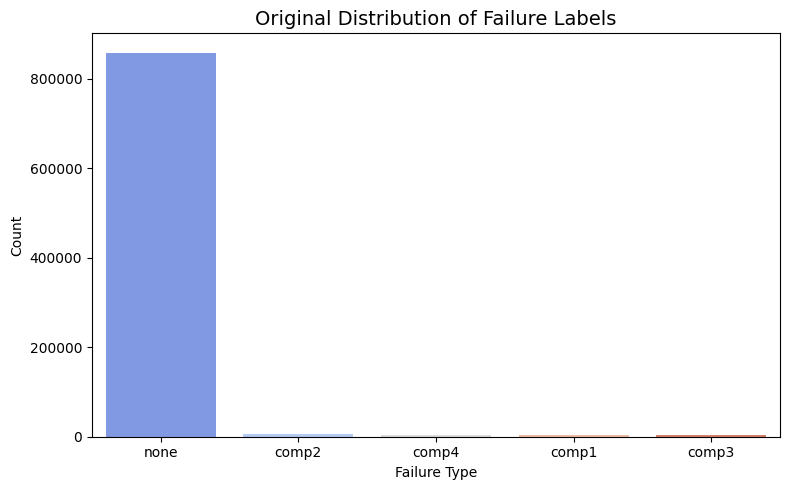

In [ ]:
failure_counts = data['failure_label'].value_counts().reset_index()
failure_counts.columns = ['failure', 'count']

# Sort by count
failure_counts = failure_counts.sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='failure', y='count', data=failure_counts, palette='coolwarm')
plt.title('Original Distribution of Failure Labels', fontsize=14)
plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### **3. Feature Engineering**

**Drop unnecessary coloumns**\
'datetime' (time-based leakage risk)\
'errorID', 'comp', 'failure' from merges (could leak future info)

In [ ]:
data_model = data.copy()

# Drop ID and text/meta fields
data_model = data_model.drop(columns=[
    'datetime', 'errorID', 'comp', 'model', 'failure', 'comp_maint', 'comp_fail'
], errors='ignore')  # ignore in case missing


**Encode Target Labels**

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data_model['failure_label'] = le.fit_transform(data_model['failure_label'])

# Save mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Class mapping:", label_mapping)


Class mapping: {'comp1': np.int64(0), 'comp2': np.int64(1), 'comp3': np.int64(2), 'comp4': np.int64(3), 'none': np.int64(4)}


**Handle imbalance class**

**Downsample the majority class**

In [ ]:
from sklearn.utils import resample

df_majority = data_model[data_model['failure_label'] == le.transform(['none'])[0]]
df_minority = data_model[data_model['failure_label'] != le.transform(['none'])[0]]

df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority)*1,
                                   random_state=42)

data_balanced = pd.concat([df_majority_downsampled, df_minority])

In [ ]:
print(data_balanced['failure_label'].value_counts())

failure_label
4    17184
1     5754
3     4287
0     4104
2     3039
Name: count, dtype: int64


**Use SMOTE for oversampling minority classes**

In [ ]:
# Drop target column to get X
X = data_balanced.drop(columns=['failure_label'])

# Get the target
y = data_balanced['failure_label']

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [ ]:
import numpy as np
unique, counts = np.unique(y_res, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(17184), np.int64(1): np.int64(17184), np.int64(2): np.int64(17184), np.int64(3): np.int64(17184), np.int64(4): np.int64(17184)}


In [ ]:
# Get the inverse transform (int → label)
from collections import Counter

# Count occurrences in y_res
counter = Counter(y_res)

# Map encoded class index back to original label
decoded_counts = {le.inverse_transform([k])[0]: v for k, v in counter.items()}
print(decoded_counts)


{'none': 17184, 'comp3': 17184, 'comp4': 17184, 'comp1': 17184, 'comp2': 17184}


<ipython-input-33-183941009>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='failure', y='count', data=data_balanced, palette='Blues_d')


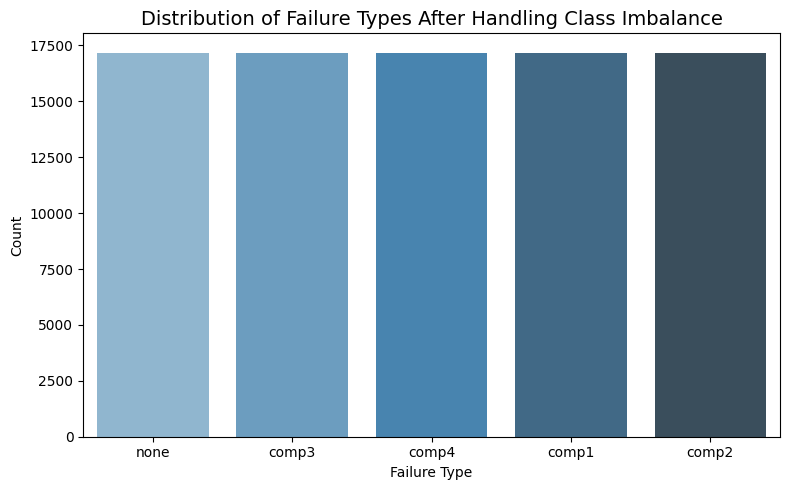

In [ ]:
# Convert the dictionary to a DataFrame
data_balanced = pd.DataFrame.from_dict(decoded_counts, orient='index', columns=['count']).reset_index()
data_balanced = data_balanced.rename(columns={'index': 'failure'})

data_balanced = data_balanced.sort_values(by='count', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='failure', y='count', data=data_balanced, palette='Blues_d')
plt.title("Distribution of Failure Types After Handling Class Imbalance", fontsize=14)
plt.xlabel("Failure Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### **4. Modelling**

### **Predict which component is likely on having failure in next 24hours**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

**Train - Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

**Train a Random Forest**

In [ ]:
model = RandomForestClassifier(n_estimators=100,random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

       comp1       0.80      0.85      0.82      3437
       comp2       0.80      0.84      0.82      3436
       comp3       0.89      0.95      0.92      3437
       comp4       0.87      0.93      0.90      3437
        none       0.75      0.55      0.64      3437

    accuracy                           0.83     17184
   macro avg       0.82      0.83      0.82     17184
weighted avg       0.82      0.83      0.82     17184



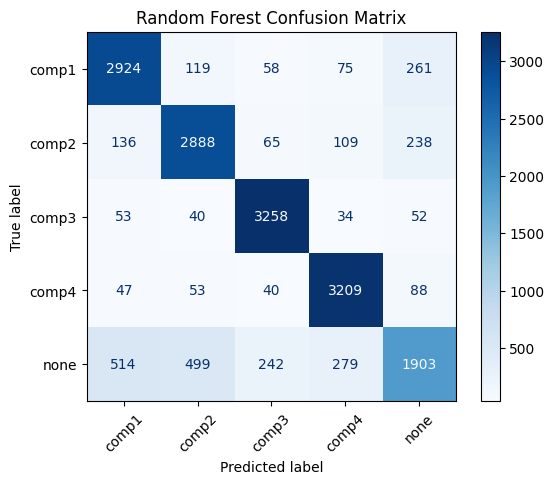

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Random Forest Confusion Matrix')
plt.show()

**Train a XGBoost**

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:51:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
              precision    recall  f1-score   support

       comp1       0.73      0.76      0.74      3437
       comp2       0.74      0.74      0.74      3436
       comp3       0.88      0.93      0.91      3437
       comp4       0.84      0.90      0.87      3437
        none       0.67      0.56      0.61      3437

    accuracy                           0.78     17184
   macro avg       0.77      0.78      0.77     17184
weighted avg       0.77      0.78      0.77     17184



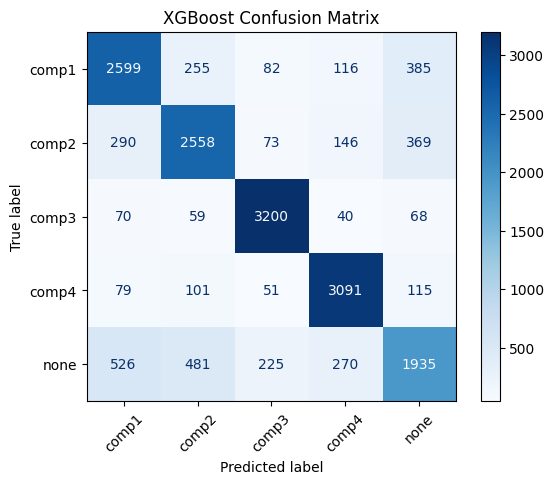

In [ ]:
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('XGBoost Confusion Matrix')
plt.show()

**Train a SVM**

In [ ]:
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train[:5000], y_train[:5000])  # Use a subset to speed up
y_pred_svm = svm_model.predict(X_test[:5000])

print("SVM Classification Report:")
print(classification_report(y_test[:5000], y_pred_svm, target_names=le.classes_))

SVM Classification Report:
              precision    recall  f1-score   support

       comp1       0.62      0.66      0.64      1026
       comp2       0.60      0.69      0.64      1016
       comp3       0.77      0.83      0.80      1005
       comp4       0.82      0.68      0.74       988
        none       0.53      0.46      0.50       965

    accuracy                           0.67      5000
   macro avg       0.67      0.66      0.66      5000
weighted avg       0.67      0.67      0.66      5000



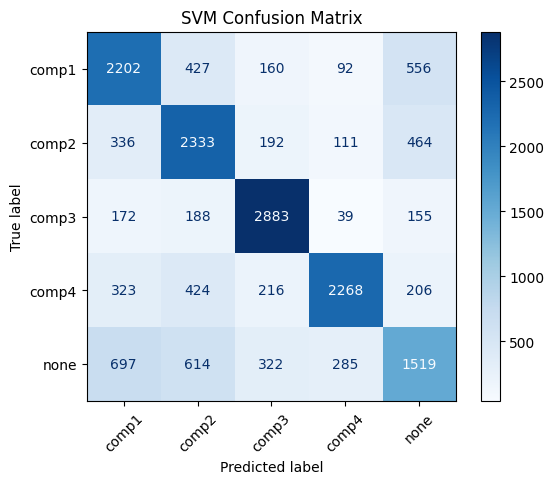

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(svm_model, X_test, y_test, display_labels=le.classes_, cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

In [ ]:
import pandas as pd

# Step 1: Predict on X_test
y_pred = model.predict(X_test)

# Step 2: Convert encoded predictions back to labels
y_pred_labels = le.inverse_transform(y_pred)

# Step 3: Create a DataFrame to store predictions
pred_df = X_test.copy()
pred_df['predicted_label'] = y_pred_labels

if 'machineID' in pred_df.columns:
    pred_df = pred_df.drop(columns=['machineID'])

# Step 4: Add back datetime and machineID
original_info = data.loc[X_test.index, ['datetime', 'machineID']].reset_index(drop=True)
pred_df = pred_df.reset_index(drop=True)
pred_df = pd.concat([original_info, pred_df], axis=1)

# Step 5: Optional - Filter only rows with predicted failure (exclude 'none')
pred_failure_only = pred_df[pred_df['predicted_label'] != 'none']

# Step 6: Save to Excel
#pred_failure_only.to_excel('predicted_failures_next_24h.xlsx', index=False)
#print("✅ Excel file 'predicted_failures_next_24h.xlsx' created successfully!")

✅ Excel file 'predicted_failures_next_24h.xlsx' created successfully!


The datetime column in the prediction output refers to the timestamp of the telemetry record (i.e., the point in time when the sensor readings were captured for a given machineID), and that data row is being used to predict whether a component will fail in the next 24 hours.

In [ ]:
# Make sure your prediction DataFrame has at least these columns:
# ['datetime', 'machineID', 'predicted_label']

# Step 1: Sort the DataFrame by datetime
pred_df_sorted = pred_df.sort_values(by=['machineID', 'datetime'])

# Step 2: Group by machineID and take the latest (last) row for each machine
latest_predictions = pred_df_sorted.groupby('machineID').tail(1)

# Step 3 (Optional): Sort by machineID for clean viewing
latest_predictions = latest_predictions.sort_values(by='machineID')

# Step 4 (Optional): Reset index
latest_predictions = latest_predictions.reset_index(drop=True)

# Display the result
print(latest_predictions.head())

# Step 5 (Optional): Save to Excel
latest_predictions.to_excel('latest_prediction_per_machine.xlsx', index=False)


             datetime  machineID        volt      rotate    pressure  \
0 2015-02-05 22:00:00          1  179.262926  299.277055  100.590286   
1 2015-02-05 23:00:00          2  176.925698  470.910304  112.047175   
2 2015-02-05 19:00:00          3  168.618198  485.182163  109.970187   
3 2015-02-05 21:00:00          4  171.000169  420.600710  100.837064   
4 2015-02-05 23:00:00          5  163.697658  491.649665  105.538570   

   vibration  age predicted_label  
0  41.813824   19           comp4  
1  54.617987   20           comp4  
2  64.118406   14           comp4  
3  52.931255   14           comp4  
4  46.235947   14           comp4  


### **Predict how frequently each machine is likely to have failures**

In [ ]:
# Step 1: Filter only rows where the prediction is a failure (exclude 'none')
failure_preds = pred_df[pred_df['predicted_label'] != 'none']

# Step 2: Count number of failures predicted per machineID
failure_counts = failure_preds['machineID'].value_counts().reset_index()
failure_counts.columns = ['machineID', 'failure_count']

# Step 3: Sort by most frequent failures
failure_counts = failure_counts.sort_values(by='failure_count', ascending=False)

# Step 4: Show top results
print(failure_counts.head())

# Step 5 (Optional): Save to Excel
failure_counts.to_excel('failure_frequency_by_machine.xlsx', index=False)


   machineID  failure_count
0         61            174
1         44            171
2         59            168
3          8            167
4         38            165


<ipython-input-56-3561507740>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='machineID', y='failure_count', data=top_machines, palette='Reds_r')


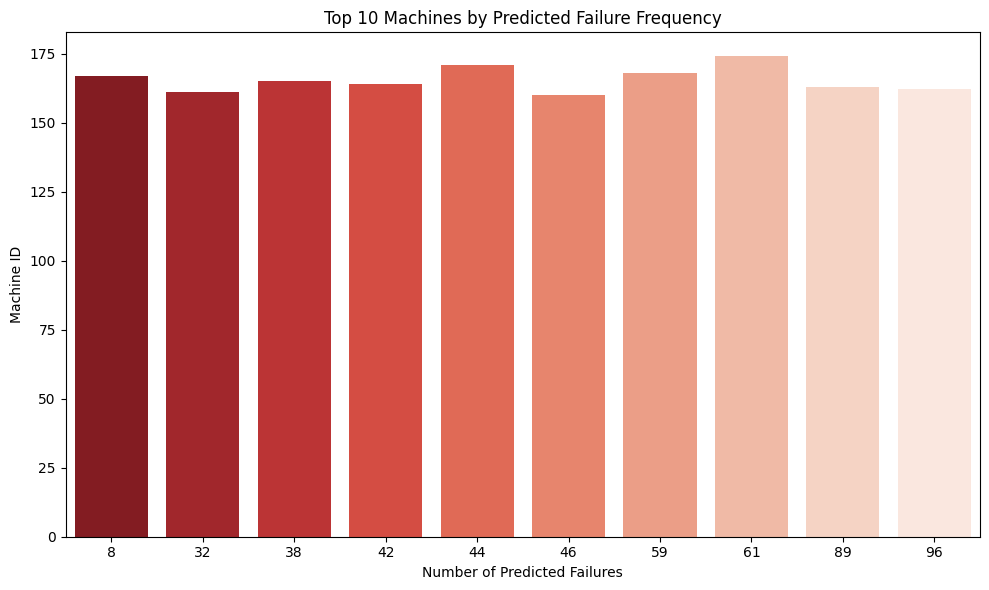

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot top 10 machines with most predicted failures
top_machines = failure_counts.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='machineID', y='failure_count', data=top_machines, palette='Reds_r')
plt.title('Top 10 Machines by Predicted Failure Frequency')
plt.xlabel('Number of Predicted Failures')
plt.ylabel('Machine ID')
plt.tight_layout()
plt.show()
